# Описание проекта
- Первая — построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

- Вторая задача — построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

In [1]:
# для работы с данными и визуализации
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

# для создания пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# для преобразования данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler 
from sklearn.impute import SimpleImputer

# для перебора моделей и параметров
from sklearn.model_selection import RandomizedSearchCV

# модели задачи 1
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

# метрики задачи 1
from sklearn.metrics import root_mean_squared_error, make_scorer

# для 2-ой задачи

# модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# метрики
from sklearn.metrics import f1_score, roc_auc_score

# для анализа признаков
import shap

## Задача 1: предсказание уровня удовлетворённости сотрудника

Для этой задачи заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

`train_job_satisfaction_rate.csv` - тренировочная выборка;

`test_features.csv` - входные признаки тестовой выборки (X_test);

`test_target_job_satisfaction_rate.csv` - целевой признак тестовой выборки (y_test);

### Шаг 1. Загрузка и отсмотр данных

In [2]:
try:
    df_rate = pd.read_csv('train_job_satisfaction_rate.csv')
    X_rate = pd.read_csv('test_features.csv')
    y_rate = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    df_rate = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
    X_rate = pd.read_csv('/datasets/test_features.csv')
    y_rate = pd.read_csv('datasets/test_target_job_satisfaction_rate.csv')        

In [3]:
df_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [4]:
X_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [5]:
y_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Данные загрузили, видно, что все считалось адекватно.

### Шаг 2. Предобработка данных

In [6]:
df_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
print('Проверка уникальных значений категориальных признаков \n')
print(df_rate['dept'].value_counts(), '\n')
print(df_rate['level'].value_counts(), '\n')
print(df_rate['workload'].value_counts())

Проверка уникальных значений категориальных признаков 

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64 

junior    1894
middle    1744
sinior     358
Name: level, dtype: int64 

medium    2066
low       1200
high       734
Name: workload, dtype: int64


In [8]:
print('Проверка уникальных значений категориальных бинарных признаков \n')
print(df_rate['last_year_promo'].value_counts(), '\n')
print(df_rate['last_year_violations'].value_counts())

Проверка уникальных значений категориальных бинарных признаков 

no     3880
yes     120
Name: last_year_promo, dtype: int64 

no     3441
yes     559
Name: last_year_violations, dtype: int64


In [9]:
# проверим на явные дупликаты строк и отдельно - в id
print('Явных повторений строк:', df_rate.duplicated().sum())
print('Повторений среди пользователей по id:', df_rate['id'].duplicated().sum())

Явных повторений строк: 0
Повторений среди пользователей по id: 0


In [10]:
df_rate[df_rate['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [11]:
df_rate[df_rate['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


По заданию пропуски необходимо обработать в пайплайне, поэтому не трогаем. (Хотя я бы обрабатывала бы здесь, с использованием группировки данных по грейду или, наоборот, отделу + зарплате. Но с другой стороны, пропуски есть и в тестовых данных, а значит их будет удобнее обработать или удалить, чтобы было одинакого для всех данных, в пайплайне.)

In [12]:
X_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [13]:
print('Проверка уникальных значений категориальных признаков \n')
print(X_rate['dept'].value_counts(), '\n')
print(X_rate['level'].value_counts(), '\n')
print(X_rate['workload'].value_counts())

Проверка уникальных значений категориальных признаков 

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64 

junior    974
middle    854
sinior    171
Name: level, dtype: int64 

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64


Видно, что в загруженности и уровне должности есть неизвестные значения, изменим их на пропуски, чтобы затем обработать в пайплайне.

In [15]:
print('Проверка уникальных значений категориальных бинарных признаков \n')
print(X_rate['last_year_promo'].value_counts(), '\n')
print(X_rate['last_year_violations'].value_counts())

Проверка уникальных значений категориальных бинарных признаков 

no     1937
yes      63
Name: last_year_promo, dtype: int64 

no     1738
yes     262
Name: last_year_violations, dtype: int64


In [16]:
# проверим на явные дупликаты строк и отдельно - в id
print('Явных повторений строк:', X_rate.duplicated().sum())
print('Повторений среди пользователей по id:', X_rate['id'].duplicated().sum())

Явных повторений строк: 0
Повторений среди пользователей по id: 0


Пропуски в тестовых признаках так же в уровне должности и отделе. Повторов или ошибок в заполнении данных нет. Среди тестовых и тренировочных признаков пять категориальных, а также три целочисленных признака, расхождений нет.

In [17]:
y_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [18]:
# проверим на явные дупликаты строк и отдельно - в id
print('Явных повторений строк:', y_rate.duplicated().sum())
print('Уникальных id столько же, сколько всего строк:', len(df_rate) == df_rate['id'].nunique(), ', а значит повторений нет')

Явных повторений строк: 0
Уникальных id столько же, сколько всего строк: True , а значит повторений нет


Учитывая, что после удаления 'id' могут появиться дупликаты, обработаем такие данные здесь.

In [19]:
# посмотрим, сколько повторений, если убрать целевой признак и id
columns_wout_id = df_rate.drop(['id', 'job_satisfaction_rate'], 1).columns.tolist()
columns_wout_id

['dept',
 'level',
 'workload',
 'employment_years',
 'last_year_promo',
 'last_year_violations',
 'supervisor_evaluation',
 'salary']

In [ ]:
mask = df_rate.duplicated(subset=columns_wout_id)
# выведем все строки, которые одинаковые у нескольких работников и повторяются несколько раз из-за этого
df_rate[mask]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
77,601267,technology,junior,low,1,no,no,4,19200,0.65
80,957940,sales,junior,medium,2,no,no,3,26400,0.46
159,874800,technology,middle,medium,8,no,no,4,40800,0.59
174,576571,hr,junior,low,1,no,no,4,13200,0.51
190,712077,sales,junior,low,1,no,no,5,12000,0.56
...,...,...,...,...,...,...,...,...,...,...
3994,855240,sales,junior,medium,2,no,no,3,20400,0.27
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


In [21]:
columns_wout_id = df_rate.drop(['id'], 1).columns.tolist()
mask = df_rate.duplicated(subset=columns_wout_id)
df_rate[mask]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
437,302957,purchasing,junior,low,1,no,no,4,15600,0.61
502,752399,sales,middle,low,7,no,no,4,28800,0.77
520,802286,sales,junior,medium,1,no,no,4,21600,0.43
676,167303,sales,junior,medium,1,no,no,3,24000,0.34
784,191841,sales,junior,medium,1,no,no,5,21600,0.44
...,...,...,...,...,...,...,...,...,...,...
3969,737303,sales,middle,medium,3,no,no,4,33600,0.47
3984,281204,technology,junior,low,2,no,no,4,15600,0.68
3989,261436,sales,middle,low,3,no,no,3,22800,0.18
3995,457950,technology,junior,high,2,no,no,3,46800,0.45


245 повторов против 1492 - то есть, для различных сотрудников при одинаковых данных - различный показатель удовлетворенности. Поэтому удалять будем только те, где одинаковые входные признаки приводят к одинаковому результату.

In [22]:
# сохраним на всякий случай удаляемые строки, хоть и не пригодятся
df_duplicated_rate = df_rate[mask]

# удалим повторяющиеся строки с одинаковым целевым значением
df_rate = df_rate[~df_rate['id'].isin(df_duplicated_rate['id'])]
df_rate.shape

(3755, 10)

Теперь проверим то же для тестовых данных. Однако, учитывая, что они разделены на два датасета, придется их объединить, чтобы проверить на повтор и признаков и целевого значения.

In [23]:
# объединим по id
df_test_rate = pd.merge(X_rate, y_rate, on='id', how='left')
df_test_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [ ]:
columns_wout_id = df_test_rate.drop('id', 1).columns.tolist()
mask = df_test_rate.duplicated(subset=columns_wout_id)

df_test_rate[mask].shape

(83, 10)

Всего 83 повтора, однако, удалять не будем, потому что это тестовые данные, а они могут отличаться и быть разными.

Вывод:
1. Проверили данные, есть небольшое количество пропусков среди данных по признакам (в уровне занимаемой должности и отделе).
2. Повторений по работникам или по всем строкам нет.
3. Неизвестное значение заполнили пропуском, чтобы обработать в пайплайне.
4. Проверили уникальность значений без 'id', были повторения, удалили их, на всякий случай сохранив в отдельном датасете. Количество значений в датасете уменьшилось не сильно, поэтому такой способ подходит.

### Шаг 3. Исследовательский анализ данных

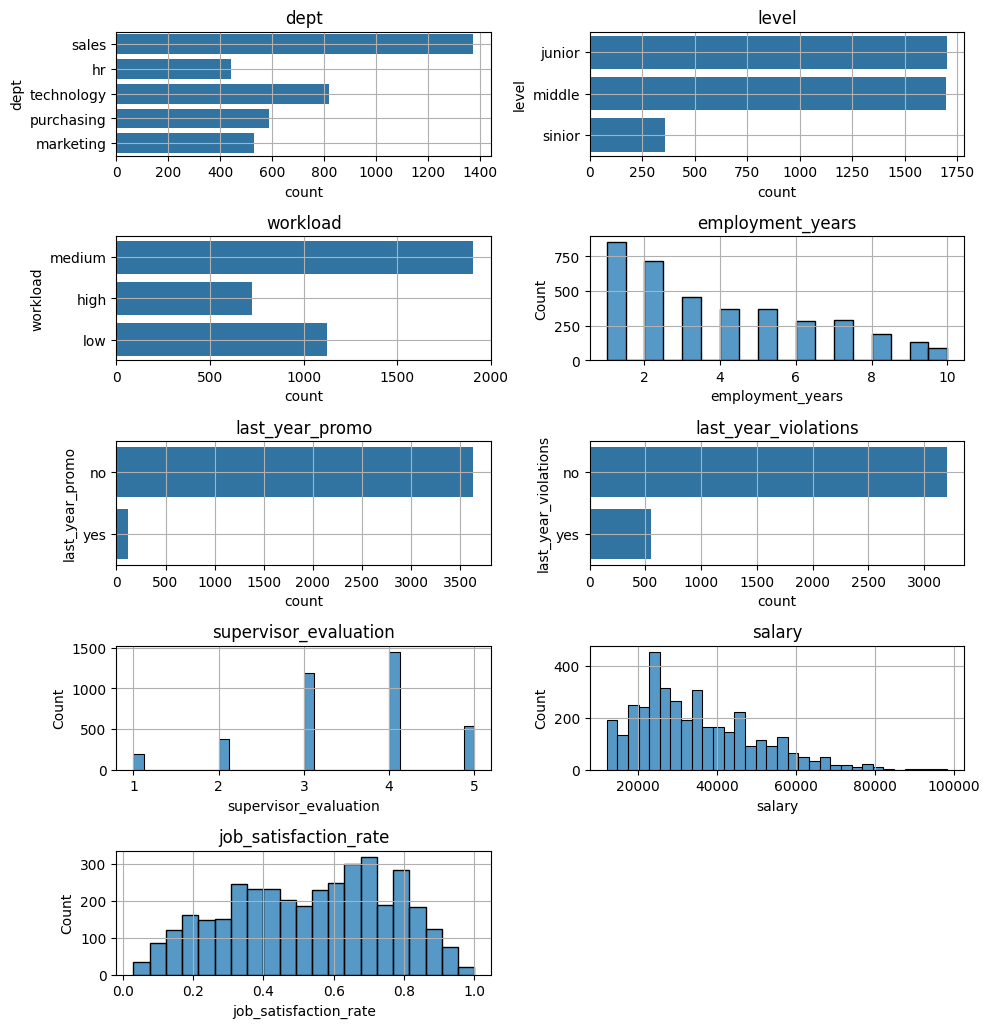

In [27]:
# отобразим все признаки, посмотрим на распределения
plt.figure(figsize=(10, 12))

for i, column in enumerate(df_rate.drop(axis=1, labels='id')):
    plt.subplot(6, 2, i+1)
    if df_rate[column].dtype == 'object':
        sns.countplot(data=df_rate[column])
    else:
        sns.histplot(data=df_rate[column])
    plt.title(f'{column}')
    plt.grid(visible=True)
    plt.tight_layout()

plt.show()

1. Данных по работникам отдела продаж больше, чем остальных.
2. Данных по старшим работникам (сеньорам) сильно меньше, чем по другим.
3. В прошлом году либо почти никто не получил повышение, либо в тренировочную выборку эти данные не попали (значение близко к нулю).
4. Есть нарушители трудового договора, пусть их и малое количетсво, но сильно больше, чем тех, кто получил повышение.
5. Зарплата, вероятно, распределена логнормально.
6. Целевой признак имеет два выделяющихся пика в оценке удовлетворенности.

In [28]:
# добавим новый признак - логарифм зарплаты, проверим, изменится ли корреляция
df_rate['log_salary'] = np.log(df_rate['salary'])

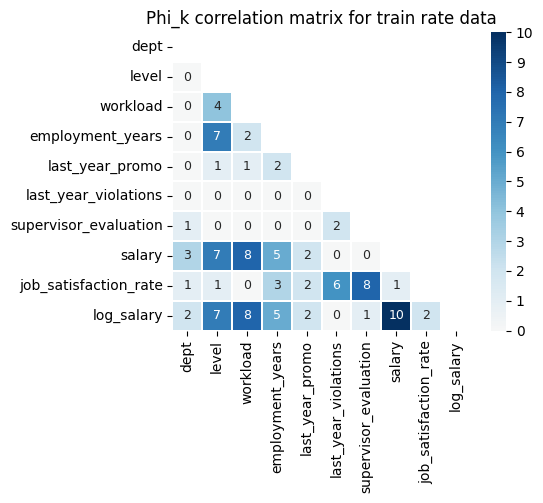

In [29]:
# создадим маску для фик с указанием количественных признаков
NUMERIC_COLS = ["employment_years", "supervisor_evaluation", "salary", "job_satisfaction_rate", "log_salary"]

# посчитаем корреляцию, увеличим на 10 и округлим, чтобы было удобнее смотреть на корреляцию (не от 0 до 1, а от 0 до 10)
corr = (df_rate.drop('id', axis=1).phik_matrix(interval_cols=NUMERIC_COLS)*10).round()

plt.figure(figsize=(6, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    mask = mask,
    cmap = 'RdBu',
    center = 0,
    square = True,
    linewidths = 0.1,
    annot = True,
    annot_kws = {'size': 9},
    cbar_kws={'ticks': [i for i in range(0, 11)]}
)

plt.title('Phi_k correlation matrix for train rate data')
plt.tight_layout()

plt.show()


Видим, что:
1. Целевой признак, уровень удовлетворенности работой, сильнее всего коррелирует с оценкой руководителя и показателем были ли нарушения за последний год. При этом умеренно коррелирует с количеством проработанных годов и было ли повышение за последний год. Посмотрим внимательнее эти показатели. 
2. Уровень зарплаты сильно коррелирует с загруженностью (видимо, чем больше работаешь, тем больше платят) и уровнем должности. А также с количеством проработанных лет (с которым сильно коррелирует и уровень должности) и отделом работы. Посмотрим на распределение уровня удовлетворенности и зарплаты в зависимости от уровня должности и загруженности.
3. Корреляция не изменилась для признака с логарифмом зарплаты. При этом он мультиколлинеарен самой зарплате. Тем не менее, воспользуемся им, потому что, как известно, логарифм от логнормального распределен нормально, что лучше для использования и анализа.

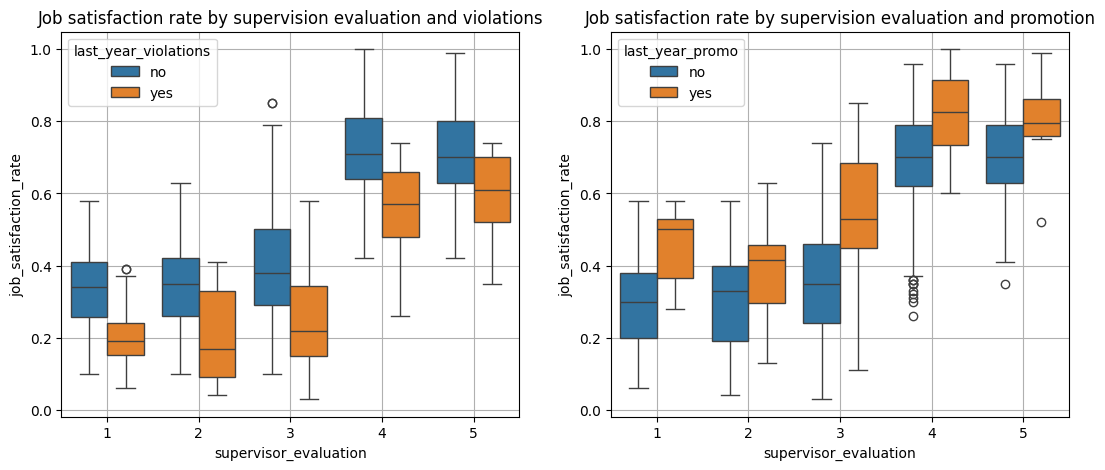

In [30]:
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
sns.boxplot(df_rate, x='supervisor_evaluation', y='job_satisfaction_rate', hue='last_year_violations')
plt.grid(visible=True)
plt.title('Job satisfaction rate by supervision evaluation and violations')

plt.subplot(1, 2, 2)
sns.boxplot(df_rate, x='supervisor_evaluation', y='job_satisfaction_rate', hue='last_year_promo')
plt.grid(visible=True)
plt.title('Job satisfaction rate by supervision evaluation and promotion')

plt.show()

1. Видим, что есть четкая корреляция между тем, оценка руководителя была ниже 3-х или выше и тем, на сколько человек удовлетворен своей работой. Возможно, можно выделить это в два признака, больше или меньше трех, если это поможет обучению модели. 

2. Несмотря на такую четкую корреляцию, при разбиении на группы по нарушениям и повышению, видно, что первое понижает уровень удовлетворенности (или уровень удовлетворенности низкий, отсюда и нарушения), а второе - наоборот, существенно повышает уровень удовлетворенности при одной и той же оценке руководителя.

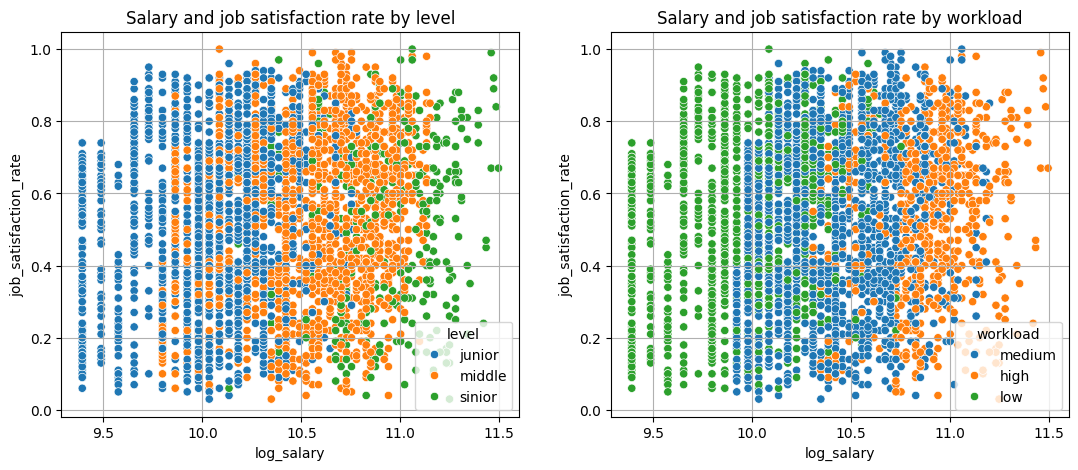

In [31]:
# визуализируем распределение данных удовлетворенности по зарплате и уровню должности и загруженности
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(df_rate, x='log_salary', y='job_satisfaction_rate', hue='level')
plt.grid(visible=True)
plt.title('Salary and job satisfaction rate by level')

plt.subplot(1, 2, 2)
sns.scatterplot(df_rate, x='log_salary', y='job_satisfaction_rate', hue='workload')
plt.grid(visible=True)
plt.title('Salary and job satisfaction rate by workload')

plt.show()

Видим, что:
- зарплата (ЗП) напрямую зависит от уровня должности и от загруженности: чем меньше уровень, тем меньше ЗП, но при этом если внутри своего грейда большая загруженность, то ЗП сопоставима с ЗП более высокого уровня. И не бывает высокого грейда с низкой загруженностью.
- Самые высокие ЗП соответствуют только самому высокому грейду. Однако даже внутри сениоров есть неудовлетворенные работой.

При этом заметно, что:
- Не бывает маленького грейда с маленькой ЗП и удовлетворенностью больше 0.8;
- Данные по ЗП до логарифма ЗП равного 10.5 - дискретные (с определенным шагом), а после - непрерываные (хаотичные).
- При более низких зарплатах сильнее на удовлетворенность влияет уровень ЗП, однако в остальном - зависимости нет (есть с высокой ЗП и грейдом, но маленькой удовлетворенностью).

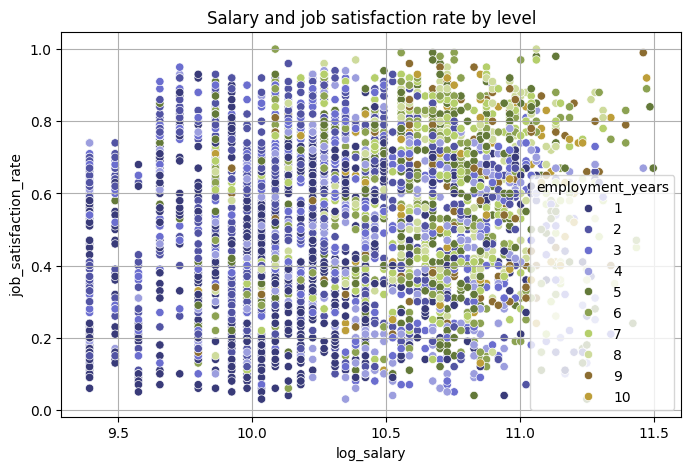

In [32]:
plt.figure(figsize=(8, 5))

sns.scatterplot(df_rate, x='log_salary', y='job_satisfaction_rate', hue='employment_years', palette='tab20b')
plt.grid(visible=True)
plt.title('Salary and job satisfaction rate by level')

plt.show()

Видно, что есть небольшая зависимость между уровнем удовлетворенности и годами работы: уровень удовлетворенности ниже 0.2 в основном у работников, кто работал меньше лет 7 лет, вне зависимости от уровня зарплаты (и грейда).


Анализировать тестовые данные не будем, потому что они должны быть неизвестны для модели и подстраиваться под них нельзя. Однако добавим логарифм от ЗП в них так же. И построим графики распределения, чтобы проверить, что распределение тестовых данных похоже.

In [33]:
df_test_rate['log_salary'] = np.log(df_test_rate['salary'])

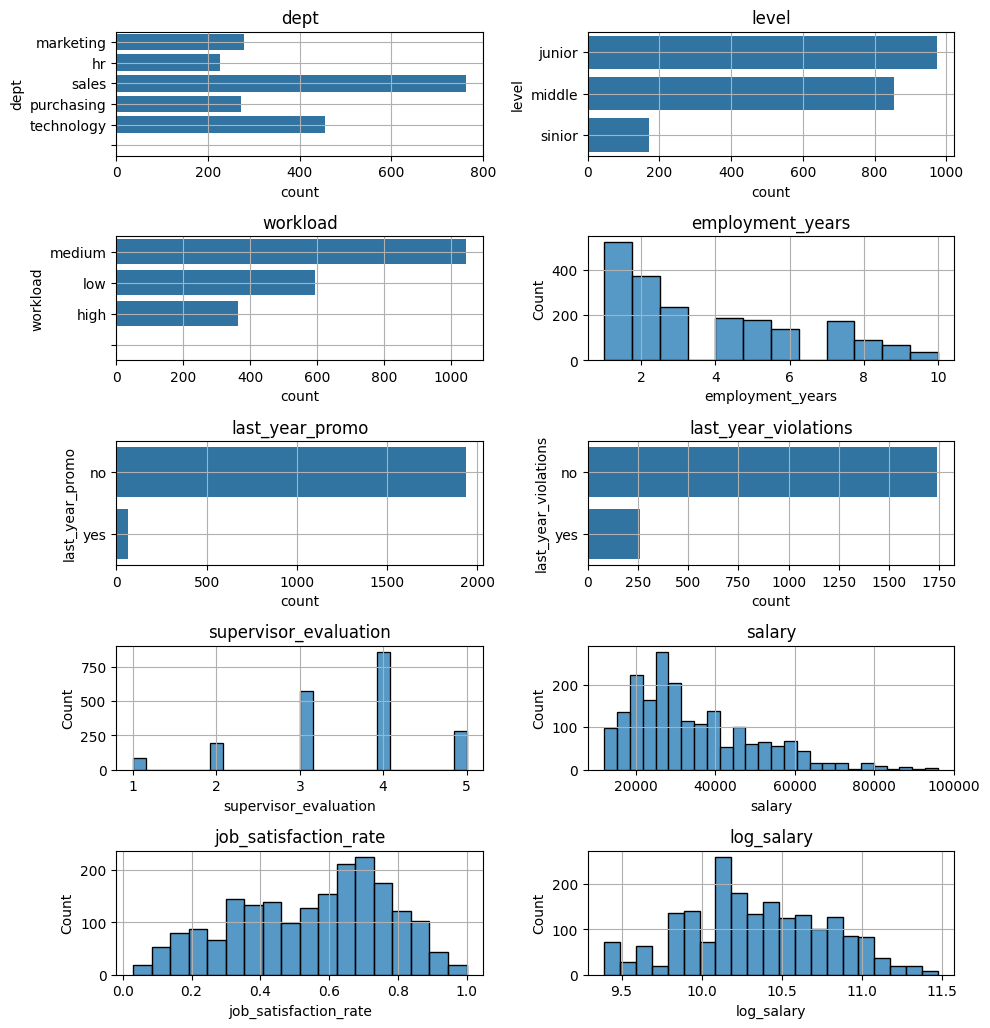

In [34]:
# отобразим все признаки, посмотрим на распределения
plt.figure(figsize=(10, 12))

for i, column in enumerate(df_test_rate.drop(axis=1, labels='id')):
    plt.subplot(6, 2, i+1)
    if df_test_rate[column].dtype == 'object':
        sns.countplot(data=df_test_rate[column])
    else:
        sns.histplot(data=df_test_rate[column])
    plt.title(f'{column}')
    plt.grid(visible=True)
    plt.tight_layout()

plt.show()

Вывод:
1. Целевой признак зависит от оценки руководителя, нарушений и повышений, количества лет работы. 
2. Зарплата зависит от грейда, загруженности и так же, от количества проработанных лет.
3. Целевой признак слабо зависит от зарплаты.

### Шаг 4-5. Пайплайн и обучение модели.

Так как задача предсказать уровень удовлетворенности от 0 до 1, воспользуемся регрессионными моделями.

In [35]:
RANDOM_STATE = 42

# удалим колонки id и с ЗП, учитывая, что есть логарифмированная ЗП
X_train = df_rate.drop(['job_satisfaction_rate', 'id', 'salary'], axis=1)
y_train = df_rate['job_satisfaction_rate']

X_test = df_test_rate.drop(labels=['id', 'salary', 'job_satisfaction_rate'], axis=1)
y_test = df_test_rate['job_satisfaction_rate']

# train_test_split выполнять не будем, потому что X_test, y_test отдельно находятся, а валидация пройзойдет при подборе модели за счет cross-validation

In [36]:
# отделим колонки с категориальными значениями
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']

# выделим колонки с количественными значениями
num_columns = ['employment_years', 'log_salary']

In [37]:
ohe_pipe = Pipeline(
    [   
        (
            # обработаем пропуски
            'SimpleImputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            # закодируем бинарные признаки или те, в которых не важен порядок (отдел)
            'ohe', 
            OneHotEncoder(drop='first', sparse_output=False, handle_unknown='infrequent_if_exist')
        )
    ],
)

ord_pipe = Pipeline(
    [
        (
            # обработаем пропуски
            'SimpleImputer_before_ord',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            # закодируем категориальные, где важен порядок
            'ord', 
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            # обработаем неизвестные значения, которые обозначили как пропуски, самым часто встречающимся значением
            'SimpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        # масштабируем численные
        ('num', StandardScaler(), num_columns)
    ],
    # оставшиеся колонки не трогаем - это оценка директора, она уже по сути как закодированный ordinalencoder'ом признак, от плохо (1), до отлично (5)
    remainder='passthrough'      
)

In [38]:
final_pipe = Pipeline(
    [
        # обработаем данные
        ('preprocessor', data_preprocessor),
        # применим модель базовую
        ('models', LinearRegression())
    ]
)

In [39]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1, 10),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), MaxAbsScaler()]
    },
    # словарь для модели SVR()
    {
        'models': [SVR()],
        'models__C': np.linspace(0.1, 5, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), MaxAbsScaler()]  
    },
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), MaxAbsScaler()]  
    },
    {
        'models': [GradientBoostingRegressor(random_state=RANDOM_STATE)],
        'models__learning_rate': np.linspace(0.05, 0.5, 10),
        'models__n_estimators': range(50, 500, 50),
        'models__max_depth': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), MaxAbsScaler()]
    }
] 

In [40]:
# определим функцию собственной метрики
def smape_func(y, y_pred):
    numenator = np.abs(y - y_pred)
    denumenator = (np.abs(y) + np.abs(y_pred)) / 2
    smape = 100 * np.mean(numenator / denumenator)
    return smape

In [41]:
# инициализируем метрику
score = make_scorer(smape_func, greater_is_better=False)
scoring = {"SMAPE": score}

In [42]:
# переберем модели с использованием случайного подбора лучших параметров и с кросс валидацией
# в качестве метрики возьмем r2, потому что по ней можно сравнивать подели в задаче регрессии
randomized_search = RandomizedSearchCV(
    final_pipe, 
    param_distributions=param_grid, 
    scoring = score, 
    random_state=RANDOM_STATE, 
    n_jobs=-1,
    cv=5, 
    n_iter=300,
    refit="SMAPE",
    return_train_score=True
)

# обучим модель
randomized_search.fit(X_train, y_train)

/home/mara/miniconda3/envs/practicum/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='infrequent_if_exist',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_viol...
                                         'models__learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
                                         'models__max_depth': range(2, 5),
                                         'models__n_estimators': range(50, 500, 50),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               MaxAbsScaler()]}],
                   random_state=42, refit='SMAPE', return_train_score=True,
                   scoring=make_scorer(smape_func, greater_is_better=False, response_method='predict'))

In [43]:
# выведем лучшую модель
best_model = randomized_search.best_estimator_
best_model['models']

GradientBoostingRegressor(learning_rate=0.15000000000000002, max_depth=4,
                          n_estimators=400, random_state=42)

In [62]:
top_10_models_cv_results = pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score')[:10]
selected_columns = ['rank_test_score', 'param_models', 'mean_score_time', 'mean_test_score', 'std_test_score', 'mean_train_score',
                    'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score',
                    'param_preprocessor__num', 'param_models__n_estimators', 'param_models__learning_rate']

top_10_models_cv_results[selected_columns]

,rank_test_score,param_models,mean_score_time,mean_test_score,std_test_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,param_preprocessor__num,param_models__n_estimators,param_models__learning_rate
42,1,GradientBoostingRegressor(random_state=42),0.076543,-12.289601,0.087630,-8.903960,-12.322116,-12.383304,-12.200488,-12.370868,-12.171228,MaxAbsScaler(),400.0,0.15
279,2,GradientBoostingRegressor(random_state=42),0.078739,-12.294596,0.085980,-8.903960,-12.331590,-12.381022,-12.200488,-12.376993,-12.182886,StandardScaler(),400.0,0.15
197,3,GradientBoostingRegressor(random_state=42),0.070138,-12.308170,0.143372,-8.571231,-12.395529,-12.495335,-12.278136,-12.064835,-12.307016,MinMaxScaler(),350.0,0.20
26,4,GradientBoostingRegressor(random_state=42),0.086019,-12.352337,0.248280,-8.118520,-12.645185,-12.592092,-12.268702,-11.958752,-12.296953,MinMaxScaler(),450.0,0.20
170,5,GradientBoostingRegressor(random_state=42),0.089916,-12.381590,0.095880,-9.241200,-12.437724,-12.536824,-12.291918,-12.280305,-12.361177,MaxAbsScaler(),250.0,0.20
51,6,GradientBoostingRegressor(random_state=42),0.060930,-12.393538,0.124003,-9.476248,-12.290495,-12.378920,-12.432084,-12.608363,-12.257829,MinMaxScaler(),300.0,0.15
122,7,GradientBoostingRegressor(random_state=42),0.063388,-12.453984,0.235698,-8.064233,-12.395649,-12.875600,-12.508249,-12.188260,-12.302163,StandardScaler(),300.0,0.30
282,8,GradientBoostingRegressor(random_state=42),0.056639,-12.464720,0.274144,-7.781357,-12.468543,-12.925497,-12.512499,-12.086266,-12.330797,MinMaxScaler(),350.0,0.30
221,9,GradientBoostingRegressor(random_state=42),0.049478,-12.502200,0.067047,-9.676380,-12.512123,-12.611991,-12.495039,-12.401547,-12.490299,StandardScaler(),200.0,0.20
143,10,GradientBoostingRegressor(random_state=42),0.049412,-12.503464,0.098273,-9.255638,-12.513667,-12.525249,-12.532284,-12.623110,-12.323011,MaxAbsScaler(),200.0,0.25


Вывели результаты обучения лучших 10 моделей. Топ 10 мест заняла модель Градиентного Бустинга, очевидно, она лучше других подошла под эту задачу. Видно, что на тестовых данных при кросс-валидации значения метрики SMAPE, по которой обучалась модель, хуже, чем на тренировочных данных: 12.3% против 8.9% (чем меньше ошибка, тем лучше). Тем не менее, это самые маленькие ошибки и они меньше 15%, что показывает высокую точность модели.

In [63]:
# выведем метрики лучшей модели на тестовых данных
print(f'r2 score of best model: {best_model.score(X_test, y_test):.2%}')

y_test_pred = best_model.predict(X_test)

print(f'RMSE of best model: {root_mean_squared_error(y_test, y_test_pred):.2}')
print(f'SMAPE of best model on train data: {np.abs(score(best_model, X_test, y_test))} is smaller than 15')

r2 score of best model: 92.76%
RMSE of best model: 0.059
SMAPE of best model on train data: 11.280789213827457 is smaller than 15


/home/mara/miniconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mara/miniconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mara/miniconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Выводы:
1. Подготовили пайплайн, предобработали и обучили модели в пайплайне с использованием случайного перебора гиперпараметров и с кросс-валидацией.
2. В предобработке перебрали несколько методов масштабирования, использовали два кодировщика - один для бинарных и непорядковых признаков, второй для порядковых категориальных признаков. 
3. Учли в предобработке пропуски в признаках и неизвестные значения. 
4. Учли, что два датасета с признаками тестовых данных и целевым признаком были загружены не в одинаковом порядке, сортировали по id.
4. Перебрали 5 моделей: линейную регрессию, дерево решений, метод опорных векторов, случайный лес и градиентный бустинг. Последние две добавили, потому что на первых трех не достигалась требуемая точность. 
5. Перебрали гиперпараметры моделей. 

6. Лучшей моделью оказался Градиентный Бустинг для регрессии (лучшие 10 мест рандомизированного поиска заняты именно этой моделью так же), на котором метрика SMAPE показала значение 11.3% на тестовых данных.

### Шаг 6. Выводы по 1 задаче

Была поставлена задача по предсказанию уровня удовлетворенности работников компании. Для решения задачи данные были исследованы на взаимосвязи, обнаружено, что уровень удовлетворенности коррелирует с оценкой руководителя (возможно, отношения с руководителем или командой влияют на целевой признак), с наличием нарушений за последний год, а также с показателем, было повышение или нет, за последний год.

Создан новый признак (логарифм зарплаты), после чего создан пайплайн с предобработкой данных и обучением на нескольких моделях (по созданной отдельно метрике SMAPE). Обученная модель достигла точности по метрике r2 равной 93% и по SMAPE (чем ниже, тем лучше) равной 11.3.

## Задача 2: предсказание увольнения сотрудника из компании

`quit` — увольнение сотрудника из компании.

### Шаг 1. Загрузка данных

In [64]:
try:
    df_quit = pd.read_csv('train_quit.csv')
    X_quit = pd.read_csv('test_features.csv')
    y_quit = pd.read_csv('test_target_quit.csv')
except:
    df_quit = pd.read_csv('/datasets/train_quit.csv')
    X_quit = pd.read_csv('/datasets/test_features.csv')
    y_quit = pd.read_csv('datasets/test_target_quit.csv')        

In [65]:
df_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [66]:
X_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [67]:
y_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Данные загружены адекватно.

### Шаг 2. Предобработка

In [68]:
df_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


In [69]:
for col in df_quit.columns:
    if df_quit[col].dtype == 'O':
        print(df_quit[col].value_counts(), '\n')

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64 

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64 

medium    2118
low       1208
high       674
Name: workload, dtype: int64 

no     3887
yes     113
Name: last_year_promo, dtype: int64 

no     3455
yes     545
Name: last_year_violations, dtype: int64 

no     2872
yes    1128
Name: quit, dtype: int64 



In [70]:
y_quit['quit'].value_counts()

no     1436
yes     564
Name: quit, dtype: int64

Данные тренировочные без пропусков, категориальные данные без ошибок, целевой признак сопоставим с тестовым. Но видно и по тренировочным и по тестовым дисбаланс классов, учтем это при обучении.

In [71]:
df_quit.drop('id', 1).describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [72]:
X_quit.drop('id', 1).describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Распределение данных сопоставимое. Помним, что в тестовых входных данных были неизвестные значения, обработаем их.

In [73]:
for col in X_quit.columns:
    if X_quit[col].dtype == 'O':
        print(X_quit[col].value_counts(), '\n')

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64 

junior    974
middle    854
sinior    171
Name: level, dtype: int64 

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64 

no     1937
yes      63
Name: last_year_promo, dtype: int64 

no     1738
yes     262
Name: last_year_violations, dtype: int64 



In [74]:
# объединим данные тестовые, чтобы соответствовали по id строки (вместо сортировки)
df_test_quit = X_quit.merge(y_quit, on='id', how='left')
df_test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,no
1,686555,hr,junior,medium,1,no,no,4,30000,no
2,467458,sales,middle,low,5,no,no,4,19200,no
3,418655,sales,middle,low,6,no,no,4,19200,no
4,789145,hr,middle,medium,5,no,no,5,40800,no


In [75]:
# ранее мы уже добавляли признак логарифма от цены, поэтому добавим сразу
df_quit['log_salary'] = np.log(df_quit['salary'])
df_test_quit['log_salary'] = np.log(df_test_quit['salary'])

Проверим тренировочные данные на провторы без id

In [83]:
columns_wout_id = df_quit.drop(['id'], 1).columns.tolist()
mask = df_quit.duplicated(subset=columns_wout_id)
# выведем все строки, которые одинаковые у нескольких работников и повторяются несколько раз из-за этого
df_quit[mask].shape

(1413, 11)

Большое количество данных, удаление стольких может сильно снизить точность модели. Кроме того, для задачи классификации повторы в данных не проблема.

Вывод:

Входные данные тренировочные без пропусков, категории совпадают между тренировочными и тестовыми, распределения числовых значений так же похожи. Пропущенные значения в тестовых данных обработали сразу. Сортировали тестовые данные, чтобы были сопоставимы. Добавили новый признак с логарифмом цены, чтобы сразу анализировать с ним и были сопоставимы данные предыдущей и текущей задачи, это может понадобится, когда будем использовать предсказания, полученные в предыдущей задаче.

### Шаг 3-4. Исследовательский анализ и Объединение данных

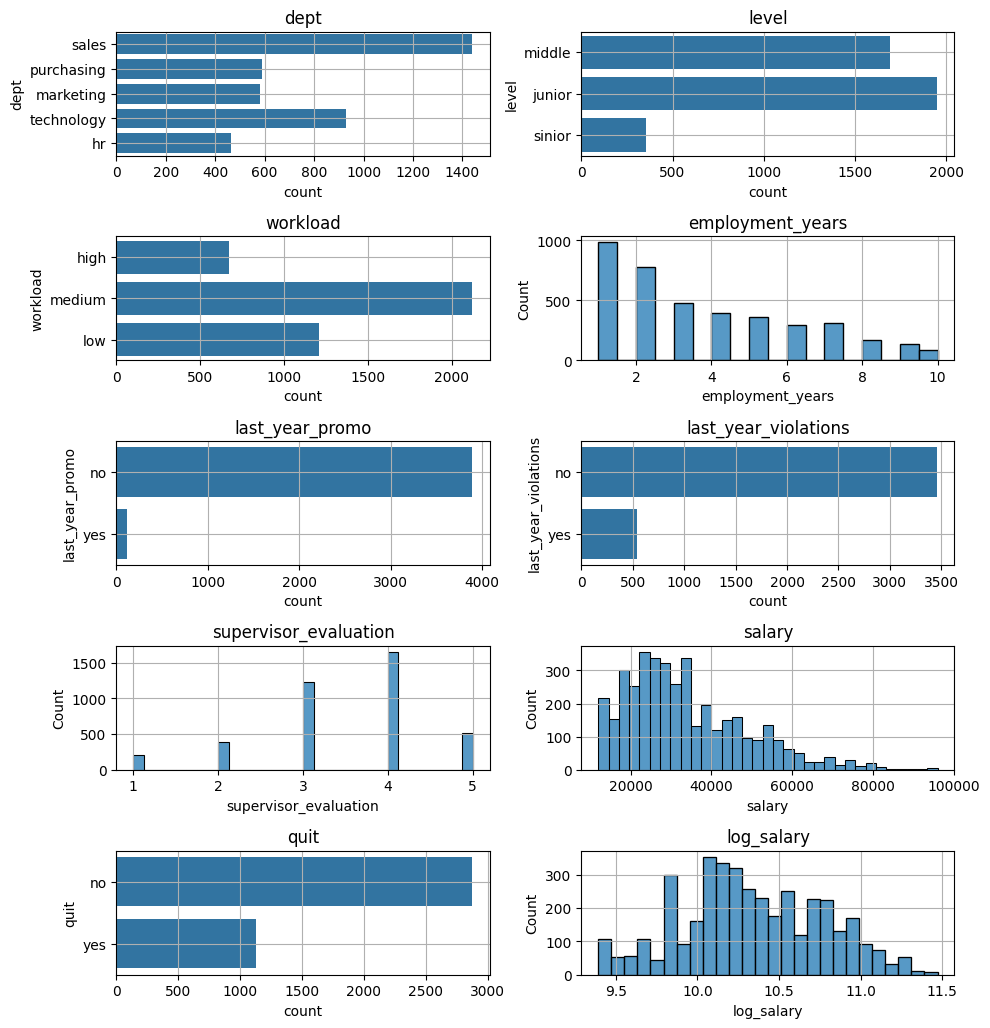

In [84]:
# отобразим все признаки, посмотрим на распределения
plt.figure(figsize=(10, 12))

for i, column in enumerate(df_quit.drop(axis=1, labels='id')):
    plt.subplot(6, 2, i+1)
    if df_quit[column].dtype == 'object':
        sns.countplot(data=df_quit[column])
    else:
        sns.histplot(data=df_quit[column])
    plt.title(f'{column}')
    plt.grid(visible=True)
    plt.tight_layout()

plt.show()

Виден дисбаланс классов, увольняющихся сотрудников сильно меньше (что хорошо). В остальном, данные сильно похожи на те, что были описаны и исследованы ранее. Видно, что распределение нового признака логаримфа зарплаты похоже на нормальное.

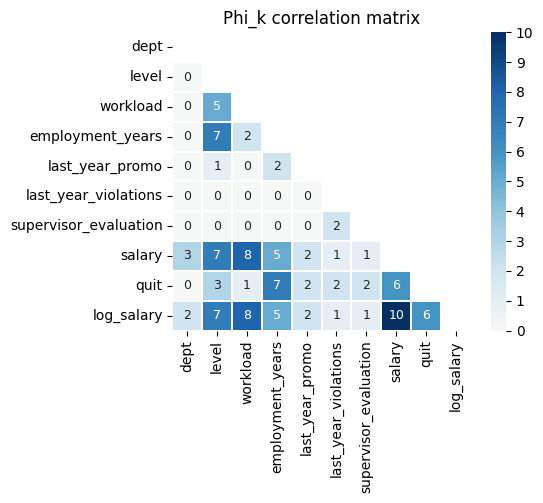

In [85]:
# создадим маску для фик с указанием количественных признаков
NUMERIC_COLS = ["employment_years", "supervisor_evaluation", "salary", "log_salary"]

# посчитаем корреляцию, увеличим на 10 и округлим, чтобы было удобнее смотреть на корреляцию (не от 0 до 1, а от 0 до 10)
corr = (df_quit.drop('id', axis=1).phik_matrix(interval_cols=NUMERIC_COLS)*10).round()

plt.figure(figsize=(6, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    mask = mask,
    cmap = 'RdBu',
    center = 0,
    square = True,
    linewidths = 0.1,
    annot = True,
    annot_kws = {'size': 9},
    cbar_kws={'ticks': [i for i in range(0, 11)]}
)

plt.title('Phi_k correlation matrix')
plt.tight_layout()

plt.show()


Видно, что целевой признак (увольнение сотрудника) коррелирует с количеством проработанных лет и с зарплатой. Исследуем эту взаимосвязь.

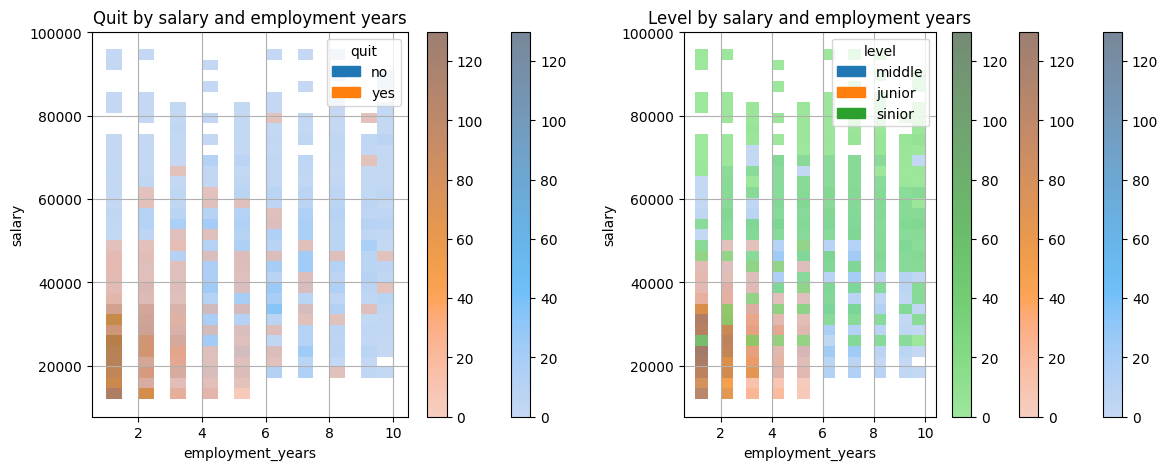

In [86]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_quit, x='employment_years', y='salary', hue='quit', cbar=True, alpha=0.7)
plt.grid(visible=True)
plt.title('Quit by salary and employment years')

plt.subplot(1, 2, 2)
sns.histplot(df_quit, x='employment_years', y='salary', hue='level', cbar=True, alpha=0.7)
plt.grid(visible=True)
plt.title('Level by salary and employment years')

plt.show()

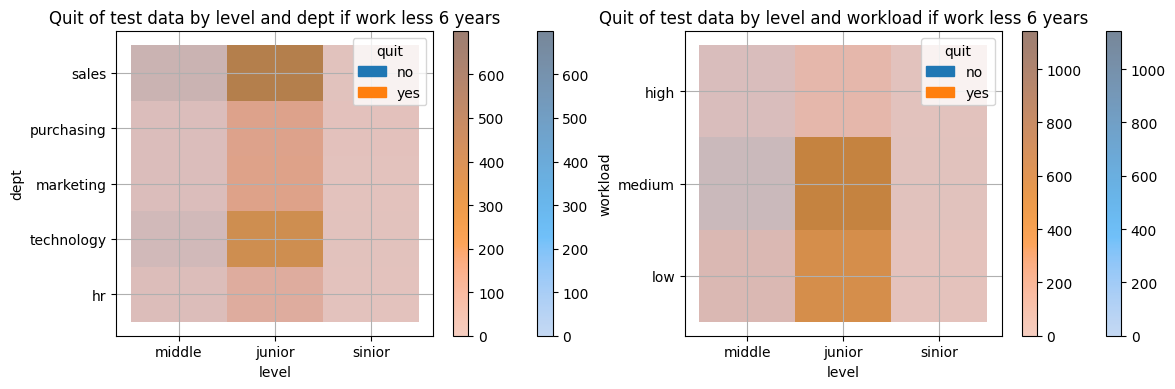

In [87]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.histplot(df_quit[df_quit['employment_years'] < 6], x='level', y='dept', hue='quit', cbar=True, alpha=0.7)
plt.grid(visible=True)
plt.title('Quit of test data by level and dept if work less 6 years')
plt.tight_layout()

plt.subplot(1, 2, 2)
sns.histplot(df_quit[df_quit['employment_years'] < 6], x='level', y='workload', hue='quit', cbar=True, alpha=0.7)
plt.grid(visible=True)
plt.title('Quit of test data by level and workload if work less 6 years')
plt.tight_layout()

plt.show()

In [ ]:
# создадим колонку с долей ушедших сотрудников от числа всех по распределению по уровню должности, отделу и занятости
part_of_quit = df_quit.pivot_table(index='level', columns=['dept', 'workload'], values='quit', aggfunc=lambda x: (x=='yes').sum() / len(x))
# выведем, подкрасив наибольшие значения внутри строки
part_of_quit.style.background_gradient(axis=1)

In [125]:
junior_mask = df_quit['level'] == 'junior'
workload_mask = df_quit['workload'] == 'low'

df_quit.loc[junior_mask & workload_mask, 'salary'].describe()

count      665.000000
mean     16558.195489
std       3167.036031
min      12000.000000
25%      14400.000000
50%      16800.000000
75%      19200.000000
max      24000.000000
Name: salary, dtype: float64

Получается, что в основном уходят новые сотрудники уровня джуниор, которые проработали меньше 5-х лет при зарплате меньше 50 тыс. А остаются в компании, в основном, сотрудники старшего грейда. При этом, если смотреть на долю ушедших сотрудников от всех, то получается:

1.  Основные, кто уходят (доля ушедших 85%) - это джуниоры с высокой загруженностью из отдела покупок (помним, что обычно, чем выше загруженность, тем выше зарплата, но зарплата для джуниоров никогда не превышает 50 тыс.), то же происходит в отделах технологий и маркетинга (> 72% джуниоров с высокой нагрузкой уходят);
2. В целом, среди джуниоров самая большая текучка по всем отделам, но помимо высокой загруженности, уходят так же те, чья загруженность маленькая. Видно, что зарплата в этом случае получается неконкурентной, то есть, очень маленькой.
3. Среди всех остальных грейдов чаще уходят те, кому "нечего делать" на рабочем месте - чья загруженность очень маленькая, в основном из отделов hr, покупок. Тем не менее, доля уволившихся других грейдов не сравнится с увольняющимися джунами.

Вывод:
Образ "уволившегося сотрудника" - джуниор из отдела продаж (или, в целом, любого другого отдела), с высокого уровня загруженностью, который получает меньше 50 тысяч. Либо джуниор с слишком низкой загруженностью и, соответственно, слишком маленькой зарплатой (от 12 до 24 тыс.).

In [127]:
# проверим совпадают ли работники, если да - то в каком датасете, в тот и добавим
print(df_quit['id'].isin(df_rate['id']).sum())
df_test_quit['id'].isin(df_test_rate['id']).sum()

0


2000

Невозможно выполнить пункт 3.3 - тренировочные данные для других работников, а значит к ним невозможно добавить предсказания предыдущей задачи и адекватно сравнить уволился сотрудник ли и какой при этом был уровень удовлетворенности. Можно, конечно, объединить тестовые данные, входные и целевой признак, и посмотреть по ним.

In [128]:
# добавим предсказанный признак в исходные данные, потому что только так мы можем корректно его объединить по своему id для каждого предсказания
df_test_rate = pd.concat([df_test_rate, pd.DataFrame({'pred_job_satisfaction_rate': y_test_pred})], axis=1)
df_test_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,log_salary,pred_job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,10.268131,0.867909
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,10.308953,0.641537
2,467458,sales,middle,low,5,no,no,4,19200,0.64,9.862666,0.665556
3,418655,sales,middle,low,6,no,no,4,19200,0.60,9.862666,0.655059
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,10.616437,0.814981


In [129]:
# добавим в этот датасет предсказанные и истинные значения удовлетворенности работой
df_test_quit = df_test_quit.merge(df_test_rate[['id', 'job_satisfaction_rate', 'pred_job_satisfaction_rate']], how='left', on='id')
df_test_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,log_salary,job_satisfaction_rate,pred_job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,no,10.268131,0.79,0.867909
1,686555,hr,junior,medium,1,no,no,4,30000,no,10.308953,0.72,0.641537
2,467458,sales,middle,low,5,no,no,4,19200,no,9.862666,0.64,0.665556
3,418655,sales,middle,low,6,no,no,4,19200,no,9.862666,0.60,0.655059
4,789145,hr,middle,medium,5,no,no,5,40800,no,10.616437,0.75,0.814981


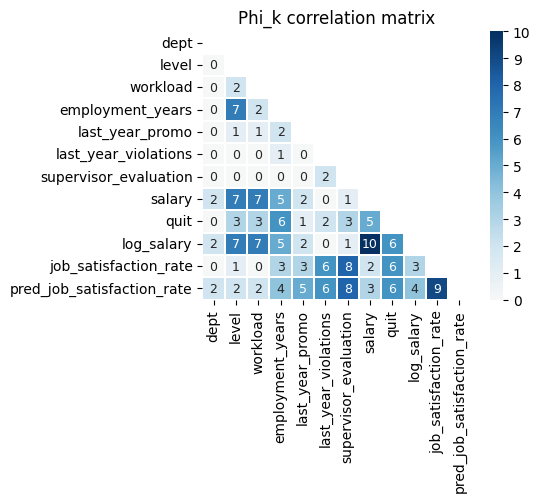

In [130]:
# создадим маску для фик с указанием количественных признаков
NUMERIC_COLS = ["employment_years", "supervisor_evaluation", "salary", "job_satisfaction_rate", "pred_job_satisfaction_rate", "log_salary"]

# посчитаем корреляцию, увеличим на 10 и округлим, чтобы было удобнее смотреть на корреляцию (не от 0 до 1, а от 0 до 10)
corr = (df_test_quit.drop('id', axis=1).phik_matrix(interval_cols=NUMERIC_COLS)*10).round()

plt.figure(figsize=(6, 5))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr,
    mask = mask,
    cmap = 'RdBu',
    center = 0,
    square = True,
    linewidths = 0.1,
    annot = True,
    annot_kws = {'size': 9},
    cbar_kws={'ticks': [i for i in range(0, 11)]}
)

plt.title('Phi_k correlation matrix')
plt.tight_layout()

plt.show()


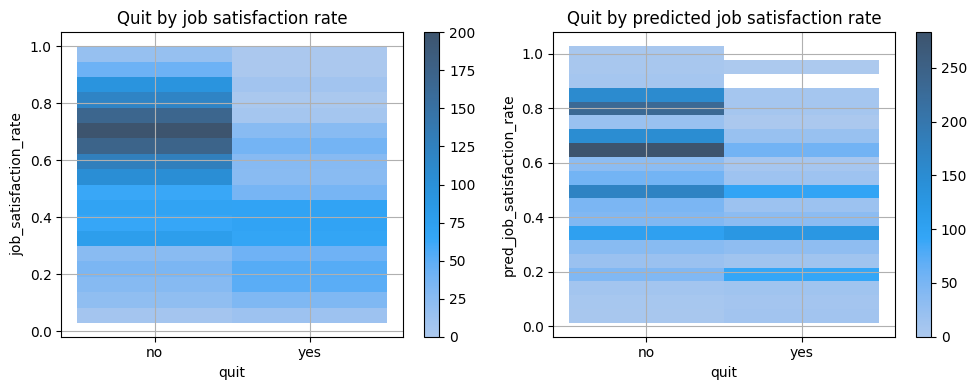

In [131]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(df_test_quit, x='quit', y='job_satisfaction_rate', cbar=True)
plt.grid(visible=True)
plt.title('Quit by job satisfaction rate')

plt.subplot(1, 2, 2)
sns.histplot(df_test_quit, x='quit', y='pred_job_satisfaction_rate', cbar=True)
plt.grid(visible=True)
plt.title('Quit by predicted job satisfaction rate')

plt.tight_layout()
plt.show()

Вывод:
1. Данные сопоставимы с теми, с которыми работали в задаче номер 1. А значит, их можно будет анализировать и использовать так же, объединять и использовать для предсказания.
2. Целевой признак - увольнение сотрудника - связан с количеством проработанных лет: в основном увольняются сотрудники, проработавшие меньше 5-6 лет, при уровне зарплаты ниже 50 000. 
3. Образ "уволившегося сотрудника" - джуниор с высокой загруженностью, но с зарплатой меньше 50 тыс., либо с маленькой загруженностью, но и зарплатой маленькой (от 12 до 24 тыс.)
4. Оценка уровня удовлетворенности сотрудника работой влияет на увольнение - среди тех, кто не уволился уровень удовлетворенностью чаще в районе 0.6-0.8, когда как у тех, кто уволился уровень ниже 0.5 зачастую.
5. Предсказанный уровень так же показывает эту тенденцию.

### Шаг 4.2 Предсказание уровня удовлетворенности для тренировочных данных

Учитывая, что по заданию надо использовать уровень удовлетворения сотрудником компанией для предсказания увольнения, а предсказанные значения есть только для сотрудников из тестовой выборки, предскажем эти значения для тренировочных данных второй задачи.

In [132]:
# создадим тренировочную выборку, сопоставимую той, на которой обучалась модель до этого
# удалим колонки id и с ЗП, учитывая, что есть логарифмированная ЗП
X_train_clf = df_quit.drop(['quit', 'id', 'salary'], axis=1)

X_train_clf.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,log_salary
0,sales,middle,high,2,no,no,4,10.896739
1,sales,junior,medium,2,no,no,4,10.225571
2,purchasing,middle,medium,5,no,no,1,10.524064
3,sales,junior,medium,2,no,yes,3,10.085809
4,marketing,junior,medium,2,no,no,5,10.134599


In [133]:
y_train_pred_for_quit = best_model.predict(X_train_clf)
# метрики вывести не можем, потому что нет для этих данных истинных значений

# добавим эти данные в тренировочные
df_quit = pd.concat([df_quit, pd.DataFrame({'pred_job_satisfaction_rate': y_train_pred_for_quit})], axis=1)
df_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,log_salary,pred_job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,10.896739,0.662582
1,814010,sales,junior,medium,2,no,no,4,27600,no,10.225571,0.840425
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,10.524064,0.320775
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,10.085809,0.325847
4,910140,marketing,junior,medium,2,no,no,5,25200,no,10.134599,0.721134


Предсказали предыдущей моделью уровень удовлетворенности для сотрудников из нового датасета - это новый признак, на этих данных модель будет обучаться предсказывать увольнение сотрудника.

### Шаг 5 - 6. Пайплайн и обучение.

In [134]:
# снова инициализируем тренировочные данные
X_train_clf = df_quit.drop(['quit', 'id', 'salary'], axis=1)
y_train_clf = df_quit['quit']

# уберем истинные значения уровня удовл., по заданию - используем предсказанные
columns_to_drop = ['id', 'quit', 'job_satisfaction_rate', 'salary']
X_test_clf = df_test_quit.drop(labels=columns_to_drop, axis=1)
y_test_clf = df_test_quit['quit']

In [135]:
# воспользуемся кодировщиком для целевого признака, это позволит сделать кодирование стандартизированным
le = LabelEncoder()
le.fit(y_train_clf)
le.classes_

array(['no', 'yes'], dtype=object)

Отлично, 0 - это сотрудник не увольняется, 1 - увольняется. Именно такое кодирование необходимо для нашей задачи.

In [136]:
# закодируем целевые признаки
y_train_clf = le.transform(y_train_clf)
y_test_clf = le.transform(y_test_clf)

In [137]:
# признаки те же, колонки те же
print(ohe_columns, ord_columns, num_columns)

['dept', 'last_year_promo', 'last_year_violations'] ['level', 'workload'] ['employment_years', 'log_salary']


Признаки те же, поэтому и предобработка та же, воспользуемся с предыдущей задачи. Масштабировать уровень удовлетворения не требуется, потому что эти значения уже от 0 до 1.

In [138]:
data_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('SimpleImputer_before_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('SimpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  OrdinalEncoder(categories=[['junior',
                                                                              'middle',
                                                                              'senior'],
                                                                             ['low',
                                                                              'medium',
                                                                              'high']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan)),
                                                 ('SimpleImputer_after_ord',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['level', 'workload']),
                                ('num', StandardScaler(),
                                 ['employment_years', 'log_salary'])])

Воспользуемся сбалансированным методом (взвешиванием классов) там, где это позволяет сделать модель, учитывая, что классы представлены не в равном количестве.

In [139]:
final_pipe = Pipeline(
    [
        # обработаем данные
        ('preprocessor', data_preprocessor),
        # применим модель базовую
        ('models', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
    ]
)
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__max_depth': range(1, 10),
        'models__min_samples_split': range(2, 5),
        'models__min_samples_leaf': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), MaxAbsScaler()]
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, class_weight='balanced')],
        'models__C': np.linspace(0.1, 5, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), MaxAbsScaler()]  
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')],
        'models__C': np.linspace(0.1, 5, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), MaxAbsScaler()]  
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), MaxAbsScaler()] 
    }
] 

In [140]:
randomized_search_clf = RandomizedSearchCV(
    final_pipe, 
    param_distributions=param_grid, 
    random_state=RANDOM_STATE, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=5, 
    n_iter=300,
    refit=True,
    return_train_score=True
)

randomized_search_clf.fit(X_train_clf, y_train_clf)

/home/mara/miniconda3/envs/practicum/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='infrequent_if_exist',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_viol...
                                         'models__C': array([0.1       , 0.64444444, 1.18888889, 1.73333333, 2.27777778,
       2.82222222, 3.36666667, 3.91111111, 4.45555556, 5.        ]),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               MaxAbsScaler()]},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               MaxAbsScaler()]}],
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [141]:
# выведем лучшую модель
best_model_clf = randomized_search_clf.best_estimator_
best_model_clf['models']

DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=9,
                       random_state=42)

In [155]:
top_10_models_cv_results_clf = pd.DataFrame(randomized_search_clf.cv_results_).sort_values(by='rank_test_score')[:10]
selected_columns = ['rank_test_score', 'param_models', 'mean_score_time', 'mean_test_score', 'std_test_score', 'mean_train_score',
                    'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score',
                    'param_preprocessor__num', 'param_models__min_samples_split', 'param_models__min_samples_leaf', 'param_models__max_depth']

top_10_models_cv_results_clf[selected_columns]

,rank_test_score,param_models,mean_score_time,mean_test_score,std_test_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,param_preprocessor__num,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth
294,1,DecisionTreeClassifier(class_weight='balanced'...,0.061505,0.934422,0.006032,0.957793,0.929859,0.933693,0.932441,0.929990,0.946128,MinMaxScaler(),3.0,9.0,6.0
201,1,DecisionTreeClassifier(class_weight='balanced'...,0.067870,0.934422,0.006032,0.957793,0.929859,0.933693,0.932441,0.929990,0.946128,StandardScaler(),4.0,9.0,6.0
281,1,DecisionTreeClassifier(class_weight='balanced'...,0.050655,0.934422,0.006032,0.957793,0.929859,0.933693,0.932441,0.929990,0.946128,MaxAbsScaler(),3.0,9.0,6.0
219,1,DecisionTreeClassifier(class_weight='balanced'...,0.070095,0.934422,0.006032,0.957793,0.929859,0.933693,0.932441,0.929990,0.946128,MaxAbsScaler(),2.0,9.0,6.0
8,1,DecisionTreeClassifier(class_weight='balanced'...,0.072844,0.934422,0.006032,0.957793,0.929859,0.933693,0.932441,0.929990,0.946128,MinMaxScaler(),2.0,9.0,6.0
299,6,DecisionTreeClassifier(class_weight='balanced'...,0.043841,0.934188,0.006163,0.958822,0.931115,0.931934,0.933975,0.928013,0.945901,StandardScaler(),4.0,6.0,6.0
125,6,DecisionTreeClassifier(class_weight='balanced'...,0.068262,0.934188,0.006163,0.958822,0.931115,0.931934,0.933975,0.928013,0.945901,MinMaxScaler(),4.0,6.0,6.0
241,6,DecisionTreeClassifier(class_weight='balanced'...,0.069064,0.934188,0.006163,0.958822,0.931115,0.931934,0.933975,0.928013,0.945901,MinMaxScaler(),2.0,6.0,6.0
274,6,DecisionTreeClassifier(class_weight='balanced'...,0.052393,0.934188,0.006163,0.958822,0.931115,0.931934,0.933975,0.928013,0.945901,StandardScaler(),2.0,6.0,6.0
138,10,"SVC(class_weight='balanced', probability=True,...",0.301298,0.933852,0.005750,0.938168,0.932062,0.929747,0.931678,0.930541,0.945234,MinMaxScaler(),NaN,NaN,NaN


Первые 5 лучших моделей получили одинаковый ранг, потому что метрика по которой обучалась модель (roc-auc) для этих моделей равна. В целом, все первые 9 мест заняла модель Дерева решений с различными гиперпараметрами, а 10-ое место лучшей модели занял Метод опорных векторов. При этом средняя оценка метрики по валидирующим данным для всех 10 мест практически равна (0.93). Вероятно, можно уменьшить количество итераций и это поможет модели не переобучаться.

In [156]:
randomized_search_clf = RandomizedSearchCV(
    final_pipe, 
    param_distributions=param_grid, 
    random_state=RANDOM_STATE, 
    scoring='roc_auc',
    n_jobs=-1,
    cv=5, 
    n_iter=100,
    refit=True,
    return_train_score=True
)

randomized_search_clf.fit(X_train_clf, y_train_clf)

/home/mara/miniconda3/envs/practicum/lib/python3.9/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_before_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='infrequent_if_exist',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_viol...
                                         'models__C': array([0.1       , 0.64444444, 1.18888889, 1.73333333, 2.27777778,
       2.82222222, 3.36666667, 3.91111111, 4.45555556, 5.        ]),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               MaxAbsScaler()]},
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               MaxAbsScaler()]}],
                   random_state=42, return_train_score=True, scoring='roc_auc')

In [157]:
top_10_models_cv_results_clf = pd.DataFrame(randomized_search_clf.cv_results_).sort_values(by='rank_test_score')[:10]
selected_columns = ['rank_test_score', 'param_models', 'mean_score_time', 'mean_test_score', 'std_test_score', 'mean_train_score',
                    'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score',
                    'param_preprocessor__num', 'param_models__min_samples_split', 'param_models__min_samples_leaf', 'param_models__max_depth']

top_10_models_cv_results_clf[selected_columns]

,rank_test_score,param_models,mean_score_time,mean_test_score,std_test_score,mean_train_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,param_preprocessor__num,param_models__min_samples_split,param_models__min_samples_leaf,param_models__max_depth
8,1,DecisionTreeClassifier(class_weight='balanced'...,0.086074,0.934422,0.006032,0.957793,0.929859,0.933693,0.932441,0.929990,0.946128,MinMaxScaler(),2.0,9.0,6.0
87,2,"SVC(class_weight='balanced', probability=True,...",0.142240,0.933798,0.005931,0.938515,0.932356,0.929530,0.932040,0.929639,0.945426,MinMaxScaler(),NaN,NaN,NaN
63,3,DecisionTreeClassifier(class_weight='balanced'...,0.051144,0.933445,0.008019,0.965129,0.932885,0.933828,0.931921,0.921699,0.946891,MinMaxScaler(),2.0,9.0,7.0
19,4,DecisionTreeClassifier(class_weight='balanced'...,0.067884,0.932857,0.008724,0.965854,0.933229,0.932781,0.932090,0.919313,0.946872,StandardScaler(),3.0,8.0,7.0
62,4,DecisionTreeClassifier(class_weight='balanced'...,0.045832,0.932857,0.008724,0.965854,0.933229,0.932781,0.932090,0.919313,0.946872,MaxAbsScaler(),2.0,8.0,7.0
94,6,DecisionTreeClassifier(class_weight='balanced'...,0.055300,0.932837,0.007914,0.966749,0.933024,0.932348,0.932873,0.920462,0.945477,MaxAbsScaler(),3.0,6.0,7.0
46,7,DecisionTreeClassifier(class_weight='balanced'...,0.050254,0.932552,0.011370,0.973696,0.935757,0.935668,0.932218,0.912117,0.946999,StandardScaler(),2.0,8.0,9.0
77,8,DecisionTreeClassifier(class_weight='balanced'...,0.056005,0.932532,0.008742,0.966356,0.932193,0.932549,0.932299,0.918993,0.946625,MaxAbsScaler(),2.0,7.0,7.0
99,8,DecisionTreeClassifier(class_weight='balanced'...,0.036818,0.932532,0.008742,0.966356,0.932193,0.932549,0.932299,0.918993,0.946625,MaxAbsScaler(),4.0,7.0,7.0
14,8,DecisionTreeClassifier(class_weight='balanced'...,0.065828,0.932532,0.008742,0.966356,0.932193,0.932549,0.932299,0.918993,0.946625,StandardScaler(),3.0,7.0,7.0


Уменьшили количество итераций подбора параметров с 300 до 100 и модель справилась точно так же, значение метрики итоговой не упало. Сохраним этот вариант, предскажем тестовые данные.

In [164]:
# выведем лучшую модель
best_model_clf = randomized_search_clf.best_estimator_
best_model_clf['models']

DecisionTreeClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=9,
                       random_state=42)

In [165]:
# выведем метрики лучшей модели на тестовых данных
y_test_pred_clf = best_model_clf.predict(X_test_clf)
y_test_proba = best_model_clf.predict_proba(X_test_clf)[:, 1]

print(f'accuracy score of best model: {best_model_clf.score(X_test_clf, y_test_clf):.2}')
print(f'ROC AUC of best model: {roc_auc_score(y_test_clf, y_test_proba):.2}')
print(f'F1 of best model: {f1_score(y_test_clf, y_test_pred_clf):.2}')

accuracy score of best model: 0.89
ROC AUC of best model: 0.92
F1 of best model: 0.82


/home/mara/miniconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mara/miniconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/mara/miniconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Вывод:
1. Данные схожи с теми, что были использованы в предыдущей задаче, поэтому предобработку выполнили ту же. Учли, что предсказанной удовлетворенности не требуется обработка, потому что эти данные уже представлены от 0 до 1.
2. Выполнили перебор моделей классификации и их гиперпараметров, а также перебор методов масштабирования: MinMaxScaler оказался лучшим.
3. Лучшей моделью оказалось Дерево решений для классификации, со сбалансированными весами классов (чтобы учитывать дисбаланс классов), максимальной глубиной равной 6 (позволяет не переобучаться) и минимальным количеством сэмплов на конечный лист - 9.
4. Метрики на тестовых данных лучшей подели показали: точность (accuracy) = 89%, площадь под кривой (roc auc) 0.92 (метрика, устойчивая к дисбалансу классов, поэтому выполняли обучение по ней), и f1 score равный 0.82.

### Анализ признаков

Для первой модели в силу того, что там нет предсказания вероятности принадлежности к классу, мы не можем использовать SHAP. Посмотрим по SHAP на второй задаче, как влияют признаки на предсказание увольнения. 

In [159]:
# предобработаем данные для построение SHAP графика
X_test_encoded_clf = best_model_clf['preprocessor'].transform(X_test_clf)

/home/mara/miniconda3/envs/practicum/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [160]:
# определим функцию, которая возвращает предсказание вероятности, нужно для SHAP
def f(x):
    return best_model_clf['models'].predict_proba(x)[:, 1]

In [ ]:
# инициализируем SHAP
explainer = shap.Explainer(f, X_test_encoded_clf)
# получаем SHAP значения
shap_values = explainer.shap_values(X_test_encoded_clf)
shap_obj = explainer(X_test_encoded_clf)

# достанем названия признаков
feature_names = best_model_clf['preprocessor'].get_feature_names_out().tolist()
shap_obj.feature_names = feature_names

PermutationExplainer explainer: 2001it [00:18, 66.81it/s]                           
PermutationExplainer explainer: 2001it [00:51, 31.08it/s]                          


In [162]:
# создадим датафрейм со значениями SHAP
df_shap = pd.DataFrame(abs(shap_values).mean(axis=0), feature_names).reset_index()
df_shap.columns = ['feature', 'shap_value']
df_shap = df_shap.sort_values('shap_value', ascending=False)
df_shap

,feature,shap_value
8,num__employment_years,0.126210
11,remainder__pred_job_satisfaction_rate,0.122065
9,num__log_salary,0.117625
7,ord__workload,0.065597
6,ord__level,0.065506
10,remainder__supervisor_evaluation,0.010662
2,ohe__dept_sales,0.003168
0,ohe__dept_marketing,0.000474
1,ohe__dept_purchasing,0.000000
3,ohe__dept_technology,0.000000


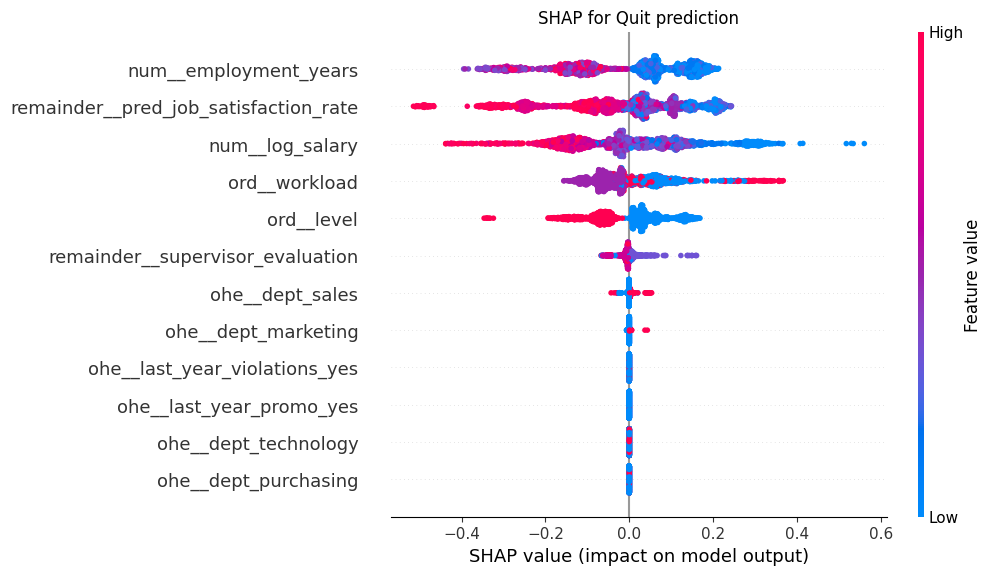

In [163]:
shap.plots.beeswarm(shap_obj, max_display=len(feature_names), show=False)
plt.title('SHAP for Quit prediction')
plt.show();

Вывод:
1. По SHAP видно, что больше всего на модель влияют количество проработанных лет (чем меньше, тем больше вероятность, что уволится сотрудник), уровень удовлетворенности работой (чем выше удовлетворенность, тем ниже вероятность, что уволится) и зарплата (чем выше, тем ниже вероятность, что уволится). 
2. Так же влияет: уровень должности, более низкая должность (джуниор) положительно влияет на предсказание класса 1 (увольнения). Загруженность влияет не так однозначно, однако видно, что более высокая загруженность влияет положительно на предсказание увольнения.
3. Все это согласуется с тем, что было выявлено на исследовательском анализе данных.

## Общий вывод.

HR-аналитики компании «Работа с заботой» предоставили задачу для оптимизирования управления персоналом: необходимо избежать финансовых потерь и оттока сотрудников для бизнеса. В рамках задачи было выделено два этапа: предсказание уровня удовлетворенности сотрудниками компанией, как показателя, который влияет на отток сотрудников, и второй этап - предсказание увольнения сотрудников и анализ факторов, которые на это влияют. 

1. Для первой задачи были проанализированы имеющиеся данные, обнаружено, что на уровень удовлетворения влияет оценка руководителя, наличие нарушений за последний год или повышений. Неизвестно, что из этого первопричина, однако было выявлена так же маленькая зависимость между степенью удовлетворенности и зарплатой. 

    Для решения первой задачи был создан пайплайн, включающий в себя предобработку данных и обучение нескольких моделей для задачи регрессии. Перебор моделей и гиперпараметров был выполнен с помощью случайного поиска с кросс-валидацией. Для обучения была создана отдельная метрика: симметричное среднее абсолютное процентное отклонение (SMAPE), который показывает, на сколько процентов отклоняются предсказанные значения относительно истинных в среднем, для лучшей модели этот показатель был 11.3% на тестовых данных. Лучшей моделью же оказался Градиентный Бустинг для регрессии, к сожалению, другие модели не давали необходимой точности. 

2. Для второй задачи - предсказания оттока (увольнения) сотрудников были проанализированы данные и выявлено, что в основном увольняются джуниоры c высокой или маленькой загруженностью и маленькой зарплатой (в целом, у джуниоров в данной компании не бывает зарплаты выше 50 тыс.). Была так же проанализирована взаимосвязь увольнения и уровня удовлетворения работой и показано, что для уволившихся сотрудников показатель удовлетворенности был в основном ниже 0.5, когда для оставшихся сотрудников в основном в районе 0.6-0.8. 

    Для предсказания оттока, а именно - уволится сотрудник или нет, были использован так же пайплайн, включающий в себя предобработку данных из предыдущей задачи (учитывая, что признаки входные те же, это стандартизирует подход) и перебор моделей классификации. Кроме того, для классификации был использован новый признак - предсказанные значения удовлетворенности работой. Перебор моделей и гиперпараметров был так же выполнен с использованием рандомизированного поиска с кросс-валидацией и учитыванием дисбаланса классов с помощью взвешивания классов внутри моделей. Лучшей моделью для данной задачи оказалось Дерево решений. 

3. Был выполнен дополнительно анализ влияния признаков на предсказание классов по SHAP, который показал ту же зависимость, что была выявлена на этапе исследовательского анализа: что на отток влияют зарплата, уровень должности, количество проработанных лет (джуниорами не работают дольше 6 лет, либо увольняются, либо получают повышение, вероятно), загруженность, уровень удовлетворенности работой. 

4. Учитывая, что на зарплату влияют уровень должности, загруженность, и все это влияет на удовлетворенность и на увольнение или нет сотрудника, при том, что в основном увольняются джуниоры с высокой нагрузкой и достаточно низкой зарплатой (ниже 50 тыс.) или с маленькой нагрузкой, но с еще меньшей зарплатой (от 12 до 24 тыс.), было бы отличным решением предлагать повышение должности или зарплаты тем джуниорам, чья нагрузка выше в их сегменте и поднять минимальную оплату. Это позволит снизить текучку новых кадров.